Engine power from 2010 fleet data


In [1]:
main_engine_power = 14871 # kW
aux_engine_power = 0.27 * main_engine_power  # = 4015.17 kW



Load factors


In [2]:
maneuvering_lf = 0.2
hotelling_lf = 0.5

Operation time

In [3]:
maneuvering_time = 1  # from Table 3-19 of EMEP/EEA air pollution emission inventory guidebook 2023
hotelling_time = 14 

Emission factors (g/kWh)


In [4]:
emission_factors = {
    "CO": {"ME": 0.451, "AE": 0.974}, 
    "NOx": {"ME": 17.7, "AE": 10.8},
    "NMVOC": {"ME": 0.238, "AE": 0.397},     # Enginge type is SSD and fuel type is BFO for ME, while for AE, they are MSD and MDO respectively
    "TSP": {"ME": 1.02, "AE": 0.215},
    "PM10": {"ME": 1.02, "AE": 0.215},
    "PM2.5": {"ME": 1.02, "AE": 0.215},
    "BC": {"ME": 0.0114, "AE": 0.0105},
}



In [5]:
def calc_emissions(power, load_factor, time, ef):
    return (power * load_factor * time * ef) / 1000

Calculating Emissions

In [6]:
emissions = {}
for pol, ef in emission_factors.items():
    man_em = calc_emissions(main_engine_power, maneuvering_lf, maneuvering_time, ef["ME"])
    hotelling_em = calc_emissions(aux_engine_power, hotelling_lf, hotelling_time, ef["AE"])
    emissions[pol] = round(man_em + hotelling_em, 3)


In [7]:
for pollutant, value in emissions.items():
    print(f"{pollutant}: {value} kg per port call")

CO: 28.717 kg per port call
NOx: 356.19 kg per port call
NMVOC: 11.866 kg per port call
TSP: 9.077 kg per port call
PM10: 9.077 kg per port call
PM2.5: 9.077 kg per port call
BC: 0.329 kg per port call


Visualizing Emission by Pollutant

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Pollutant': ['CO', 'NOx', 'NMVOC', 'TSP', 'PM10', 'PM2.5', 'BC'],
    'Emissions_kg': [28.717, 356.19, 11.866, 9.077, 9.077, 9.077, 0.329]
}

df = pd.DataFrame(data)

df.head()

,Pollutant,Emissions_kg
0,CO,28.717
1,NOx,356.190
2,NMVOC,11.866
3,TSP,9.077
4,PM10,9.077


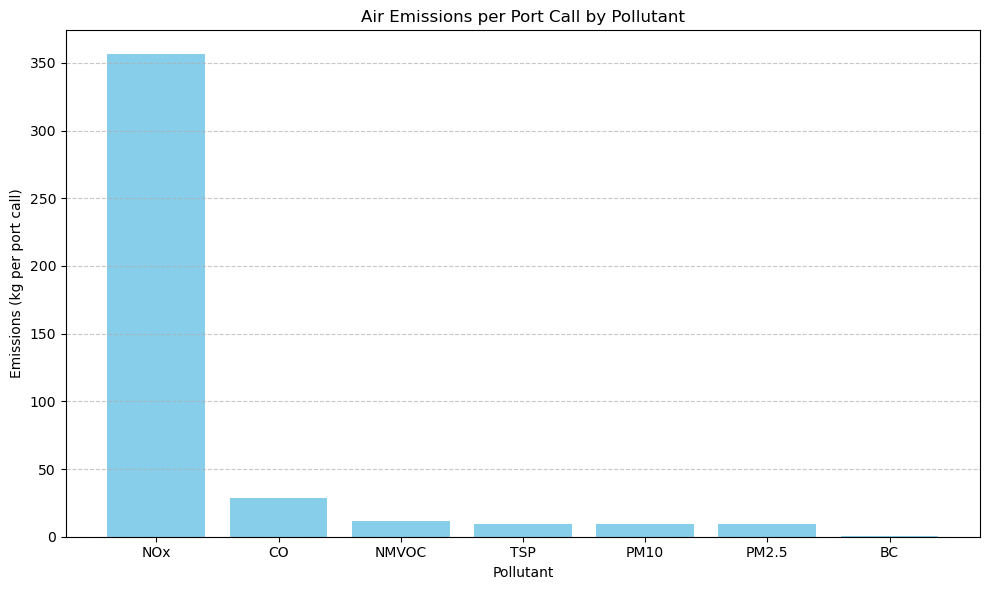

In [16]:
df = df.sort_values(by= 'Emissions_kg', ascending= False)


plt.figure(figsize=(10, 6))
plt.bar(df['Pollutant'], df['Emissions_kg'], color='skyblue')
plt.xlabel('Pollutant')
plt.ylabel('Emissions (kg per port call)')
plt.title('Air Emissions per Port Call by Pollutant')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('emission_by_pollutant.png', dpi=300)

plt.show()


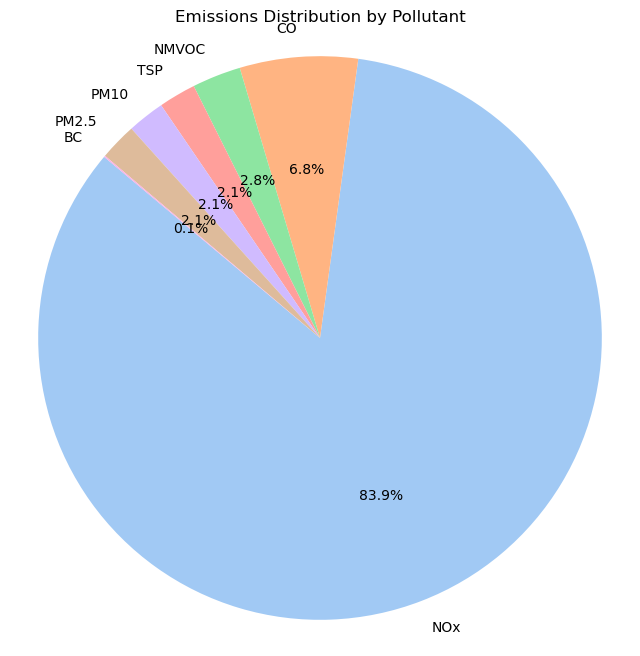

In [10]:
import seaborn as sns

colors = sns.color_palette('pastel', n_colors=len(df))

plt.figure(figsize=(8, 8))
plt.pie(df['Emissions_kg'], labels=df['Pollutant'], autopct='%1.1f%%',
        startangle=140, colors=colors)
plt.title('Emissions Distribution by Pollutant')
plt.axis('equal')  
plt.show()

Calculating CO2 emission from the auxiliary engine (without shore power)

In [11]:
SFOC_kg_per_kWh = 0.194  # kg fuel per kWh, for MSD engine using MDO/MGO
CO2_per_kg_fuel = 3.206  # kg CO₂ per kg fuel, taken from IPCC/EEA defaults

aux_CO2 = SFOC_kg_per_kWh * CO2_per_kg_fuel * aux_engine_power * hotelling_lf * hotelling_time
print(f"CO₂ from the auxiliary enginge: {aux_CO2} kg")

CO₂ from the auxiliary enginge: 17481.03835716 kg


Shore Power Scenario (Baseline Replacement)

In [12]:
aux_engine_power = 4015.17 # kW
hotelling_time = 14 
hotelling_lf = 0.5
eu_grid_factor = 0.242   # kg CO₂/kWh #Baseline for emission reduction
shore_power_kWh = aux_engine_power * hotelling_lf * hotelling_time #Energy demand
shore_power_CO2 = round(shore_power_kWh * eu_grid_factor, 3)
print(f"Shore power energy use: {shore_power_kWh} kWh") #Same as auxiliary enginge energy usage but with only CO2 emission
print(f"CO₂ from shore power: {shore_power_CO2} kg")


Shore power energy use: 28106.190000000002 kWh
CO₂ from shore power: 6801.698 kg


Percentage reduction of CO2 upon switching to shore power

In [13]:
reduction = aux_CO2 - shore_power_CO2
percent_reduction = (reduction / aux_CO2) * 100

print(f"CO₂ reduction: {reduction:.2f} kg ({percent_reduction:.1f}%)")

CO₂ reduction: 10679.34 kg (61.1%)


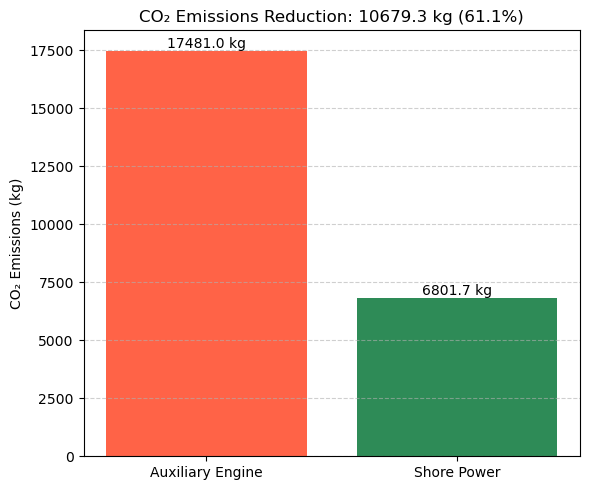

In [19]:
labels = ['Auxiliary Engine', 'Shore Power']
values = [aux_CO2, shore_power_CO2]
colors = ['tomato', 'seagreen']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color=colors)

# Annotating bars
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 5, f"{val:.1f} kg", 
             ha='center', va='bottom', fontsize=10)

plt.title(f"CO₂ Emissions Reduction: {reduction:.1f} kg ({percent_reduction:.1f}%)")
plt.ylabel("CO₂ Emissions (kg)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('CO2_emission_reduction.png',dpi=300 )
plt.show()